# Robust boosted stumps. The notebook is partially based on Wong and Kolter, 2018.

In [32]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
import data
from stump_ensemble import StumpEnsemble
from tree_ensemble import TreeEnsemble
from train import robust_boost
from utils import Logger

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")
np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Training of `plain` model started.
Tree: if x[1] < 0.8045: 0.2500 else -0.2938
iter: 1  [test] err 30.00% adv_err_lb 45.00% adv_err 45.00% adv_err_ub 45.00% | [valid] err 30.00% adv_err 45.00% | [train] err 30.00% adv_err 45.00% loss 0.89443 (0.01 sec)
Tree: if x[1] < -10.0000: 0.0625 else 0.1438
iter: 2  [test] err 25.00% adv_err_lb 65.00% adv_err 65.00% adv_err_ub 65.00% | [valid] err 25.00% adv_err 65.00% | [train] err 25.00% adv_err 65.00% loss 0.77463 (0.01 sec)
Tree: if x[1] < 2.0867: 0.2500 else -0.1260
iter: 3  [test] err 25.00% adv_err_lb 65.00% adv_err 65.00% adv_err_ub 65.00% | [valid] err 25.00% adv_err 65.00% | [train] err 25.00% adv_err 65.00% loss 0.68299 (0.02 sec)
Tree: if x[0] < -1.4704: 0.6750 else 0.5312
iter: 4  [test] err 15.00% adv_err_lb 55.00% adv_err 55.00% adv_err_ub 55.00% | [valid] err 15.00% adv_err 55.00% | [train] err 15.00% adv_err 55.00% loss 0.49198 (0.02 sec)
Tree: if x[1] < -0.6766: 0.5150 else 0.7456
iter: 5  [test] err 0.00% adv_err_lb 55.00% adv_

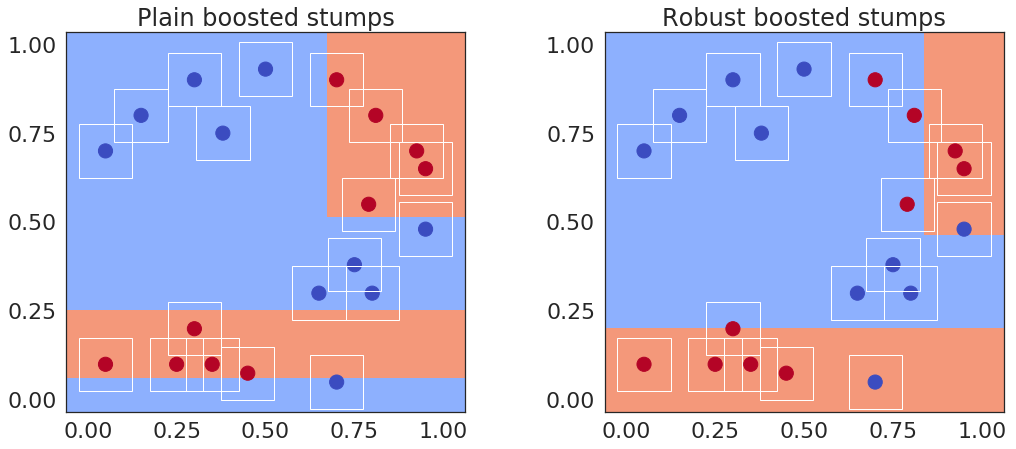

In [33]:
def plot_grid(ensemble, ax):
    grid_size = 1000
    XX, YY = np.meshgrid(np.linspace(-0.1, 1.1, grid_size), np.linspace(-0.1, 1.1, grid_size))
    X0 = np.stack([np.ravel(XX), np.ravel(YY)]).T
    y_pred = ensemble.predict(X0)
    ZZ = y_pred.reshape(grid_size, grid_size)
    
    # reflects just class assignment
    ax.contourf(XX,YY,ZZ, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))
    # reflects the classifier's predictions
    # ax.contourf(XX,YY,ZZ, cmap="coolwarm", levels=np.linspace(-np.abs(y_pred).max(),np.abs(y_pred).max(),10))
    ax.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=200)
    ax.axis("equal")
    axis_margin = 0.035
    ax.set_xlim([-axis_margin, 1.0+axis_margin])
    ax.set_ylim([-axis_margin, 1.0+axis_margin])

    for x in X:
        rect_center = (x[0]-eps_dataset, x[1]-eps_dataset)
        rect = patches.Rectangle(rect_center, 2*eps_dataset, 2*eps_dataset, fill=False)
        ax.add_patch(rect)
    
    ticks = [0.0, 0.25, 0.5, 0.75, 1.0]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(model_name)

weak_learner = 'stump'
# dataset = 'toy_2d_{}s'.format(weak_learner)  # toy_2d_trees, toy_2d_xor, toy_2d_wong
dataset = 'toy_2d_trees'
X, y, eps_dataset = data.all_datasets_dict[dataset]()

models_names = ['Plain boosted {}s'.format(weak_learner), 
                'Robust boosted {}s'.format(weak_learner)]
if weak_learner == 'stump':
    models = ['plain', 'robust_exact']
elif weak_learner == 'tree':
    models = ['plain', 'robust_bound']
else:
    raise ValueError('wrong weak learner')
# models = ['plain', 'robust_bound', 'robust_exact']
fig, axs = plt.subplots(1, len(models), figsize=(1.2*len(models)*7, 7))
for i, (model, model_name) in enumerate(zip(models, models_names)):
    print('Training of `{}` model started.'.format(model))
    eps, eps_eval = eps_dataset, eps_dataset
    n_iter, lr = 15, 1.0
    log, model_path, metrics_path = Logger(''), '', ''  # nothing will be saved
    
    if weak_learner == 'stump':
        ensemble = StumpEnsemble('stump', 2, lr)
    elif weak_learner == 'tree':
        ensemble = TreeEnsemble('tree', 2, lr, 1, 0, 8)
    else:
        raise ValueError('wrong weak learner')
    robust_boost(ensemble, X, y, X, y, X, y, n_iter, eps,
                 eps_eval, model, log, model_path, metrics_path)
    plot_grid(ensemble, axs[i])
fig.subplots_adjust(wspace=0.35)
plt.savefig('plots/plain_robust_{}.pdf'.format(dataset), bbox_inches='tight')

